In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cython
%load_ext Cython

We now use a pure C structure to represent a 3D vector. We also implement all operations we need by hand in pure C.

In [4]:
%%cython
cimport cython
import numpy as np
cimport numpy as np
DBL = np.double
ctypedef np.double_t DBL_C
from libc.math cimport sqrt

cdef int w, h

cdef struct Vec3:
    double x, y, z
    
cdef Vec3 vec3(double x, double y, double z):
    cdef Vec3 v
    v.x = x
    v.y = y
    v.z = z
    return v

cdef double dot(Vec3 x, Vec3 y):
    return x.x * y.x + x.y * y.y + x.z * y.z

cdef Vec3 normalize(Vec3 x):
    cdef double n
    n = sqrt(x.x * x.x + x.y * x.y + x.z * x.z)
    return vec3(x.x/n,  x.y/n, x.z/n)

cdef double max(double x, double y):
    return x if x > y else y

cdef double min(double x, double y):
    return x if x < y else y

cdef double clip_(double x, double m, double M):
    return min(max(x, m), M)

cdef Vec3 clip(Vec3 x, double m, double M):
    return vec3(clip_(x.x, m, M), clip_(x.y, m, M), clip_(x.z, m, M),)

cdef Vec3 add(Vec3 x, Vec3 y):
    return vec3(x.x + y.x, x.y + y.y, x.z + y.z)

cdef Vec3 subtract(Vec3 x, Vec3 y):
    return vec3(x.x - y.x, x.y - y.y, x.z - y.z)

cdef Vec3 minus(Vec3 x):
    return vec3(-x.x, -x.y, -x.z)

cdef Vec3 multiply(Vec3 x, Vec3 y):
    return vec3(x.x * y.x, x.y * y.y, x.z * y.z)
    
cdef Vec3 multiply_s(Vec3 x, double c):
    return vec3(x.x * c, x.y * c, x.z * c)

cdef double intersect_sphere(Vec3 O, 
                      Vec3 D, 
                      Vec3 S, 
                      double R):
    # Return the distance from O to the intersection of the ray (O, D) with the 
    # sphere (S, R), or +inf if there is no intersection.
    # O and S are 3D points, D (direction) is a normalized vector, R is a scalar.
    cdef double a, b, c, disc, distSqrt, q, t0, t1
    cdef Vec3 OS
    
    a = dot(D, D)
    OS = subtract(O, S)
    b = 2 * dot(D, OS)
    c = dot(OS, OS) - R * R
    disc = b * b - 4 * a * c
    if disc > 0:
        distSqrt = sqrt(disc)
        q = (-b - distSqrt) / 2.0 if b < 0 else (-b + distSqrt) / 2.0
        t0 = q / a
        t1 = c / q
        t0, t1 = min(t0, t1), max(t0, t1)
        if t1 >= 0:
            return t1 if t0 < 0 else t0
    return 1000000

cdef Vec3 trace_ray(Vec3 O, Vec3 D,):
    
    cdef double t, radius, diffuse, specular_k, specular_c, DF, SP
    cdef Vec3 M, N, L, toL, toO, col_ray, \
        position, color, color_light, ambient

    # Sphere properties.
    position = vec3(0., 0., 1.)
    radius = 1.
    color = vec3(0., 0., 1.)
    diffuse = 1.
    specular_c = 1.
    specular_k = 50.
    
    # Light position and color.
    L = vec3(5., 5., -10.)
    color_light = vec3(1., 1., 1.)
    ambient = vec3(.05, .05, .05)
    
    # Find first point of intersection with the scene.
    t = intersect_sphere(O, D, position, radius)
    # Return None if the ray does not intersect any object.
    if t == 1000000:
        col_ray.x = 1000000
        return col_ray
    # Find the point of intersection on the object.
    M = vec3(O.x + D.x * t, O.y + D.y * t, O.z + D.z * t)
    N = normalize(subtract(M, position))
    toL = normalize(subtract(L, M))
    toO = normalize(subtract(O, M))
    DF = diffuse * max(dot(N, toL), 0)
    SP = specular_c * max(dot(N, normalize(add(toL, toO))), 0) ** specular_k
    
    return add(ambient, add(multiply_s(color, DF), multiply_s(color_light, SP)))

def run(int w, int h):
    cdef DBL_C[:,:,:] img = np.zeros((h, w, 3))
    cdef Vec3 img_
    cdef int i, j
    cdef double x, y
    cdef Vec3 O, Q, D, col_ray
    cdef double w_ = float(w)
    cdef double h_ = float(h)
    
    col_ray = vec3(0., 0., 0.)
    
    # Camera.
    O = vec3(0., 0., -1.)  # Position.
        
    # Loop through all pixels.
    for i in range(w):
        Q = vec3(0., 0., 0.)
        for j in range(h):
            x = -1. + 2*(i)/w_
            y = -1. + 2*(j)/h_
            Q.x = x
            Q.y = y
            col_ray = trace_ray(O, normalize(subtract(Q, O)))
            if col_ray.x == 1000000:
                continue
            img_ = clip(col_ray, 0., 1.)
            img[h - j - 1, i, 0] = img_.x
            img[h - j - 1, i, 1] = img_.y
            img[h - j - 1, i, 2] = img_.z
    return img

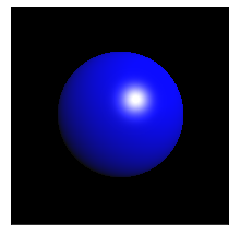

In [5]:
w, h = 200, 200

img = run(w, h)
plt.imshow(img);
plt.xticks([]); plt.yticks([]);

In [6]:
%timeit run(w, h)

1.95 ms ± 146 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
